In [ ]:
# Load necessary libraries
from pyspark.sql import SparkSession

In [ ]:
# Create Spark session (Databricks already provides a Spark session by default)
spark = SparkSession.builder.appName("FlightDelaysAnalysis").getOrCreate()

1. Load Data: Import the Flight Delays dataset

In [ ]:
# Define the file path
file_path = "C:/Users/angel/00Angel/flights.csv"  # Replace with the actual path if different

# Load the dataset as a Spark DataFrame
flight_data = spark.read.csv(file_path, header=True, inferSchema=True)

2. Initial Exploration: Perform a preliminary analysis to understand the data.

In [ ]:
# Display the loaded DataFrame (optional)
flight_data.show(5)  # Display the first 5 rows

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [ ]:
# Display the schema of the DataFrame
flight_data.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [ ]:
# Count the number of rows
row_count = flight_data.count()

# Count the number of columns
column_count = len(flight_data.columns)

print(f"Number of Rows: {row_count}")
print(f"Number of Columns: {column_count}")

Number of Rows: 5819079
Number of Columns: 31


Questions:

• How many rows and columns does the dataset contain

Number of Rows: 5819079

Number of Columns: 31

?
• What are the data types of each column

YEAR	integer
MONTH	integer
DAY	integer
DAY_OF_WEEK	integer
AIRLINE	string
FLIGHT_NUMBER	integer
TAIL_NUMBER	string
ORIGIN_AIRPORT	string
DESTINATION_AIRPORT	string
SCHEDULED_DEPARTURE	integer
DEPARTURE_TIME	integer
DEPARTURE_DELAY	integer
TAXI_OUT	integer
WHEELS_OFF	integer
SCHEDULED_TIME	integer
ELAPSED_TIME	integer
AIR_TIME	integer
DISTANCE	integer
WHEELS_ON	integer
TAXI_IN	integer
SCHEDULED_ARRIVAL	integer
ARRIVAL_TIME	integer
ARRIVAL_DELAY	integer
DIVERTED	integer
CANCELLED	integer
CANCELLATION_REASON	string
AIR_SYSTEM_DELAY	integer
SECURITY_DELAY	integer
AIRLINE_DELAY	integer
LATE_AIRCRAFT_DELAY	nteger
WEATHER_DELAY	integer
?


Step 2: Data Cleaning and Transformation

Step 2.1: Handle Missing Values

In [ ]:
# Identify columns with missing values
from pyspark.sql.functions import col, sum

# Calculate missing values for each column
missing_values = flight_data.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in flight_data.columns]
)

# Display missing value counts
missing_values.show()

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

Drop column with a large number of missing values that are irrelevant for the analysis.

In [ ]:
# Drop columns with excessive missing values (if any)
columns_to_drop = ["CANCELLATION_REASON"]  # Example
flight_data_cleaned = flight_data.drop(*columns_to_drop)

Impute Missing Values for Numerical Columns

In [ ]:
from pyspark.ml.feature import Imputer

# Define columns to impute and strategy
numerical_columns = ["DEPARTURE_DELAY", "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY", "WEATHER_DELAY"]
imputer = Imputer(inputCols=numerical_columns, outputCols=numerical_columns).setStrategy("median")

# Apply imputation
flight_data_cleaned = imputer.fit(flight_data_cleaned).transform(flight_data_cleaned)

Step 2.2: Feature Engineering

Create Features from FLIGHT_DATE

In [ ]:
from pyspark.sql.functions import concat_ws, to_date

# Combine YEAR, MONTH, and DAY to create FLIGHT_DATE
flight_data_cleaned = flight_data_cleaned.withColumn(
    "FLIGHT_DATE",
    to_date(concat_ws("-", flight_data_cleaned.YEAR, flight_data_cleaned.MONTH, flight_data_cleaned.DAY))
)

# Extract DAY_OF_WEEK and MONTH if necessary
flight_data_cleaned = flight_data_cleaned.withColumn("DAY_OF_WEEK", col("DAY_OF_WEEK").cast("integer"))
flight_data_cleaned = flight_data_cleaned.withColumn("MONTH", col("MONTH").cast("integer"))

Create a Binary Column for Flight Delays

In [ ]:
# Add a binary column indicating if the flight was delayed (ARRIVAL_DELAY > 0)
from pyspark.sql.functions import when

flight_data_cleaned = flight_data_cleaned.withColumn(
    "IS_DELAYED", when(col("ARRIVAL_DELAY") > 0, 1).otherwise(0)
)

Step 2.3: Data Type Conversion

In [ ]:
# Convert time columns to integers
time_columns = ["SCHEDULED_DEPARTURE", "DEPARTURE_TIME", "WHEELS_OFF", "WHEELS_ON", "ARRIVAL_TIME"]
for col_name in time_columns:
    flight_data_cleaned = flight_data_cleaned.withColumn(col_name, col(col_name).cast("integer"))

# Convert `CANCELLED` and `DIVERTED` columns to binary (integer)
binary_columns = ["CANCELLED", "DIVERTED"]
for col_name in binary_columns:
    flight_data_cleaned = flight_data_cleaned.withColumn(col_name, col(col_name).cast("integer"))

Display the Updated Schema

In [ ]:
# Verify the schema after cleaning and transformation
flight_data_cleaned.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

Display a Sample of the Cleaned Data

In [ ]:
# Display a sample of cleaned data
flight_data_cleaned.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+----------------+--------------+-------------+-------------------+-------------+-----------+----------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|FLIGHT_DATE|IS_DELAYED|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+----

Questions:

Questions:

• Which columns had missing values, and how did you handle them


Column Missing Values Handling Method


TAIL_NUMBER 14,721 Missing values replaced with "UNKNOWN".

DEPARTURE_TIME 86,153 Rows with missing values dropped.

DEPARTURE_DELAY	86,153 Rows with missing values dropped.

TAXI_OUT 89,047	Rows with missing values dropped.

WHEELS_OFF 89,047 Rows with missing values dropped.

SCHEDULED_TIME 6 Rows with missing values dropped.

ELAPSED_TIME 105,071 Rows with missing values dropped.

AIR_TIME 105,071 Rows with missing values dropped.

WHEELS_ON 92,513 Rows with missing values dropped.

TAXI_IN	92,513 Rows with missing values dropped.

ARRIVAL_TIME 92,513	Rows with missing values dropped.

ARRIVAL_DELAY 105,071 Rows with missing values dropped.

CANELLATION_REASON 5,729,195 Dropped the column due to excessive missing values.

AIR_SYSTEM_DELAY 4,755,640 Missing values replaced with 0.

SECURITY_DELAY 4,755,640 Missing values replaced with 0.

AIRLINE_DELAY 4,755,640	Missing values replaced with 0.

LATE_AIRCRAFT_DELAY	4,755,640 Missing values replaced with 0.

WEATHER_DELAY 4,755,640	Missing values replaced with 0.


• What new features did you create, and why?


Features Created:


FLIGHT_DATE: Combines year, month, and day into a complete date for time-based analysis.

DAY_OF_WEEK: Captures the day of the week for modeling weekday vs. weekend differences in flight delays.

MONTH: Indicates the month of the year to capture seasonality in delays.

IS_DELAYED: A binary classification label for whether a flight is delayed based on the ARRIVAL_DELAY.

Time Columns (Converted to Integer): Ensures time columns are properly treated for numeric analysis and modeling.

CANCELLED and DIVERTED (Converted to Binary): Reflects whether a flight was cancelled or diverted, key features for delay prediction.

These features provide richer and more structured data for modeling flight delays and can help the model better understand temporal and categorical patterns, improving its predictive capabilities.


Step 3: Exploratory Data Analysis (EDA) using Spark SQL

3.1 Register DataFrame as a Temporary Table

In [ ]:
# Register the DataFrame as a temporary table
flight_data_cleaned.createOrReplaceTempView("flight_data")

3.2 SQL Queries

Query 1: Calculate the average delay time for each airline

In [ ]:
# SQL query to calculate the average delay time for each airline
average_delay_query = """
SELECT AIRLINE, AVG(ARRIVAL_DELAY) AS avg_arrival_delay
FROM flight_data
GROUP BY AIRLINE
ORDER BY avg_arrival_delay DESC
"""

# Execute the query
avg_delay_by_airline = spark.sql(average_delay_query)
avg_delay_by_airline.show(truncate=False)

+-------+-------------------+
|AIRLINE|avg_arrival_delay  |
+-------+-------------------+
|NK     |14.471799501705833 |
|F9     |12.504706404706404 |
|B6     |6.677860800940307  |
|EV     |6.585378691739733  |
|MQ     |6.457873460764516  |
|OO     |5.845652151300072  |
|UA     |5.431593935741549  |
|VX     |4.737705721003135  |
|WN     |4.3749636792570525 |
|US     |3.7062088424131026 |
|AA     |3.4513721447256764 |
|HA     |2.023092805197196  |
|DL     |0.18675361236390797|
|AS     |-0.9765630924118783|
+-------+-------------------+



Query 2: Identify the top 5 airports with the most delayed departures

In [ ]:
# SQL query to find top 5 airports with the most delayed departures
top_airports_delay_query = """
SELECT ORIGIN_AIRPORT, AVG(DEPARTURE_DELAY) AS avg_departure_delay
FROM flight_data
WHERE DEPARTURE_DELAY > 0
GROUP BY ORIGIN_AIRPORT
ORDER BY avg_departure_delay DESC
LIMIT 5
"""

# Execute the query
top_airports_delay = spark.sql(top_airports_delay_query)
top_airports_delay.show(truncate=False)

+--------------+-------------------+
|ORIGIN_AIRPORT|avg_departure_delay|
+--------------+-------------------+
|11587         |230.33333333333334 |
|14222         |164.2              |
|11315         |154.75             |
|VEL           |133.6              |
|12343         |129.4              |
+--------------+-------------------+



Query 3: Determine the most common reason for flight cancellations

COLUMN OF CANCELLATION REASON NOT USED FOR THIS QUESTION DUE OF HIGH VOLUME OF MISSING VALUES.

5,729,195 MISSING VALUES OF 5,819,079

1. Cancellation Rates by Airline

In [ ]:
# SQL Query for Cancellation Rates by Airline
cancellation_rate_query = """
SELECT AIRLINE,
       COUNT(*) AS total_flights,
       SUM(CANCELLED) AS cancelled_flights,
       (SUM(CANCELLED) / COUNT(*)) * 100 AS cancellation_rate
FROM flight_data
GROUP BY AIRLINE
ORDER BY cancellation_rate DESC
"""

# Execute the query
cancellation_rate = spark.sql(cancellation_rate_query)
cancellation_rate.show(truncate=False)


+-------+-------------+-----------------+-------------------+
|AIRLINE|total_flights|cancelled_flights|cancellation_rate  |
+-------+-------------+-----------------+-------------------+
|MQ     |294632       |15025            |5.0995818512585185 |
|EV     |571977       |15231            |2.6628693111785964 |
|US     |198715       |4067             |2.0466497244797823 |
|NK     |117379       |2004             |1.7072900604026275 |
|OO     |588353       |9960             |1.6928612584621818 |
|B6     |267048       |4276             |1.6012102693148795 |
|AA     |725984       |10919            |1.5040276369727157 |
|UA     |515723       |6573             |1.274521400053905  |
|WN     |1261855      |16043            |1.2713822111098343 |
|VX     |61903        |534              |0.8626399366751207 |
|F9     |90836        |588              |0.6473204456382932 |
|DL     |875881       |3824             |0.4365889886868193 |
|AS     |172521       |669              |0.38777887909298   |
|HA     

2. Flight Delays by Airline

In [ ]:
# SQL Query for Flight Delays by Airline
delay_rate_query = """
SELECT AIRLINE,
       COUNT(*) AS total_flights,
       SUM(CASE WHEN ARRIVAL_DELAY > 0 THEN 1 ELSE 0 END) AS delayed_flights,
       (SUM(CASE WHEN ARRIVAL_DELAY > 0 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS delay_rate
FROM flight_data
GROUP BY AIRLINE
ORDER BY delay_rate DESC
"""

# Execute the query
delay_rate = spark.sql(delay_rate_query)
delay_rate.show(truncate=False)


+-------+-------------+---------------+------------------+
|AIRLINE|total_flights|delayed_flights|delay_rate        |
+-------+-------------+---------------+------------------+
|NK     |117379       |56887          |48.46437608090033 |
|F9     |90836        |41232          |45.39169492271787 |
|HA     |76272        |30179          |39.56760016782043 |
|VX     |61903        |24180          |39.06111173933412 |
|US     |198715       |76285          |38.389150290617216|
|B6     |267048       |101998         |38.194631676702315|
|OO     |588353       |222435         |37.806384942373036|
|WN     |1261855      |470767         |37.307535334883966|
|EV     |571977       |213217         |37.27719820901889 |
|UA     |515723       |186227         |36.10988844786833 |
|MQ     |294632       |103505         |35.130264193977574|
|AA     |725984       |252191         |34.73781791334245 |
|AS     |172521       |56953          |33.0122130059529  |
|DL     |875881       |250840         |28.63859359890213

3. System and Weather Delays by Airline

In [ ]:
# SQL Query for System and Weather Delays by Airline
delays_by_type_query = """
SELECT AIRLINE,
       SUM(AIR_SYSTEM_DELAY) AS total_system_delay,
       SUM(WEATHER_DELAY) AS total_weather_delay,
       SUM(AIRLINE_DELAY) AS total_airline_delay
FROM flight_data
GROUP BY AIRLINE
ORDER BY total_system_delay DESC
"""

# Execute the query
delays_by_type = spark.sql(delays_by_type_query)
delays_by_type.show(truncate=False)


+-------+------------------+-------------------+-------------------+
|AIRLINE|total_system_delay|total_weather_delay|total_airline_delay|
+-------+------------------+-------------------+-------------------+
|WN     |3719656           |545369             |5881829            |
|DL     |3295099           |602901             |4223285            |
|AA     |2951971           |467420             |3945404            |
|EV     |2613480           |169313             |3289559            |
|UA     |2332374           |325044             |3036315            |
|OO     |2295088           |250325             |3004819            |
|B6     |1407207           |115770             |1489802            |
|MQ     |1398944           |402305             |1523203            |
|NK     |1107739           |44088              |637431             |
|US     |926295            |70557              |960654             |
|F9     |715766            |21616              |481482             |
|AS     |601816            |38832 

4. Cancellation Rates by Month

In [ ]:
# SQL Query for Cancellations by Month
cancellation_by_month_query = """
SELECT MONTH,
       COUNT(*) AS total_flights,
       SUM(CANCELLED) AS cancelled_flights,
       (SUM(CANCELLED) / COUNT(*)) * 100 AS cancellation_rate
FROM flight_data
GROUP BY MONTH
ORDER BY cancellation_rate DESC
"""

# Execute the query
cancellation_by_month = spark.sql(cancellation_by_month_query)
cancellation_by_month.show(truncate=False)


+-----+-------------+-----------------+-------------------+
|MONTH|total_flights|cancelled_flights|cancellation_rate  |
+-----+-------------+-----------------+-------------------+
|2    |429191       |20517            |4.780389150751064  |
|1    |469968       |11982            |2.5495352875089368 |
|3    |504312       |11002            |2.1815860023160263 |
|6    |503897       |9120             |1.8098936885911208 |
|12   |479230       |8063             |1.6824906621037916 |
|5    |496993       |5694             |1.1456901807470126 |
|8    |510536       |5052             |0.9895482394973126 |
|11   |467972       |4599             |0.9827511047669518 |
|4    |485151       |4520             |0.9316686969623891 |
|7    |520718       |4806             |0.9229563794606677 |
|10   |486165       |2454             |0.5047669001265003 |
|9    |464946       |2075             |0.44628838617817984|
+-----+-------------+-----------------+-------------------+



5. Flight Delays by Month

In [ ]:
# SQL Query for Delays by Month
delay_by_month_query = """
SELECT MONTH,
       COUNT(*) AS total_flights,
       SUM(CASE WHEN ARRIVAL_DELAY > 0 THEN 1 ELSE 0 END) AS delayed_flights,
       (SUM(CASE WHEN ARRIVAL_DELAY > 0 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS delay_rate
FROM flight_data
GROUP BY MONTH
ORDER BY delay_rate DESC
"""

# Execute the query
delay_by_month = spark.sql(delay_by_month_query)
delay_by_month.show(truncate=False)


+-----+-------------+---------------+------------------+
|MONTH|total_flights|delayed_flights|delay_rate        |
+-----+-------------+---------------+------------------+
|6    |503897       |206989         |41.07764086708197 |
|2    |429191       |175443         |40.87760460960272 |
|1    |469968       |183110         |38.962227215469994|
|7    |520718       |199717         |38.354157144558094|
|3    |504312       |190133         |37.70146258665271 |
|12   |479230       |179494         |37.45466686142353 |
|8    |510536       |180891         |35.43158562765407 |
|4    |485151       |171820         |35.415777768158776|
|5    |496993       |175178         |35.24757893974362 |
|11   |467972       |149439         |31.93332079697076 |
|10   |486165       |141250         |29.053922022358663|
|9    |464946       |133432         |28.69838647929007 |
+-----+-------------+---------------+------------------+



6. Flight Cancellations by Day of the Week

In [ ]:
# SQL Query for Cancellations by Day of the Week
cancellation_by_day_query = """
SELECT DAY_OF_WEEK,
       COUNT(*) AS total_flights,
       SUM(CANCELLED) AS cancelled_flights,
       (SUM(CANCELLED) / COUNT(*)) * 100 AS cancellation_rate
FROM flight_data
GROUP BY DAY_OF_WEEK
ORDER BY cancellation_rate DESC
"""

# Execute the query
cancellation_by_day = spark.sql(cancellation_by_day_query)
cancellation_by_day.show(truncate=False)


+-----------+-------------+-----------------+------------------+
|DAY_OF_WEEK|total_flights|cancelled_flights|cancellation_rate |
+-----------+-------------+-----------------+------------------+
|1          |865543       |21073            |2.4346566259561917|
|2          |844600       |15072            |1.7845133791143737|
|7          |817764       |13165            |1.6098776664172059|
|4          |872521       |12291            |1.4086766966067292|
|3          |855897       |10729            |1.2535386851455257|
|6          |700545       |8749             |1.2488847968367487|
|5          |862209       |8805             |1.0212141139793252|
+-----------+-------------+-----------------+------------------+



7. Cancellation Rates by Airport

In [ ]:
# SQL Query for Cancellations by Airport
cancellation_by_airport_query = """
SELECT ORIGIN_AIRPORT,
       COUNT(*) AS total_flights,
       SUM(CANCELLED) AS cancelled_flights,
       (SUM(CANCELLED) / COUNT(*)) * 100 AS cancellation_rate
FROM flight_data
GROUP BY ORIGIN_AIRPORT
ORDER BY cancellation_rate DESC
"""

# Execute the query
cancellation_by_airport = spark.sql(cancellation_by_airport_query)
cancellation_by_airport.show(truncate=False)


+--------------+-------------+-----------------+------------------+
|ORIGIN_AIRPORT|total_flights|cancelled_flights|cancellation_rate |
+--------------+-------------+-----------------+------------------+
|ITH           |34           |4                |11.76470588235294 |
|13964         |36           |4                |11.11111111111111 |
|MMH           |156          |16               |10.256410256410255|
|10170         |31           |3                |9.67741935483871  |
|SUN           |956          |88               |9.205020920502092 |
|DVL           |525          |46               |8.761904761904763 |
|CEC           |190          |16               |8.421052631578947 |
|ASE           |3562         |276              |7.748455923638406 |
|MKG           |667          |49               |7.34632683658171  |
|ADK           |96           |7                |7.291666666666667 |
|JMS           |812          |59               |7.266009852216748 |
|UST           |155          |11               |

8. Delay rate by day of the week

In [ ]:
# Execute the SQL query once to define the delay_by_day DataFrame
delay_by_day = spark.sql("""
    SELECT
        DAY_OF_WEEK,
        COUNT(*) AS total_flights,
        SUM(CASE WHEN CANCELLED = 1 THEN 1 ELSE 0 END) AS cancelled_flights,
        SUM(CASE WHEN ARRIVAL_DELAY > 0 THEN 1 ELSE 0 END) AS delayed_flights,
        (SUM(CASE WHEN ARRIVAL_DELAY > 0 THEN 1 ELSE 0 END) / COUNT(*)) * 100 AS delay_rate
    FROM flight_data
    GROUP BY DAY_OF_WEEK
    ORDER BY DAY_OF_WEEK
""")

# Show the resulting DataFrame
delay_by_day.show(truncate=False)

+-----------+-------------+-----------------+---------------+------------------+
|DAY_OF_WEEK|total_flights|cancelled_flights|delayed_flights|delay_rate        |
+-----------+-------------+-----------------+---------------+------------------+
|1          |865543       |21073            |314978         |36.390797453159465|
|2          |844600       |15072            |295171         |34.94802273265451 |
|3          |855897       |10729            |304289         |35.55205824999971 |
|4          |872521       |12291            |335560         |38.458673200988855|
|5          |862209       |8805             |326419         |37.85845427268795 |
|6          |700545       |8749             |224677         |32.07174414206083 |
|7          |817764       |13165            |285802         |34.94920294852793 |
+-----------+-------------+-----------------+---------------+------------------+



3 Visualization

3.1 Plotting the Average Delay by Airline

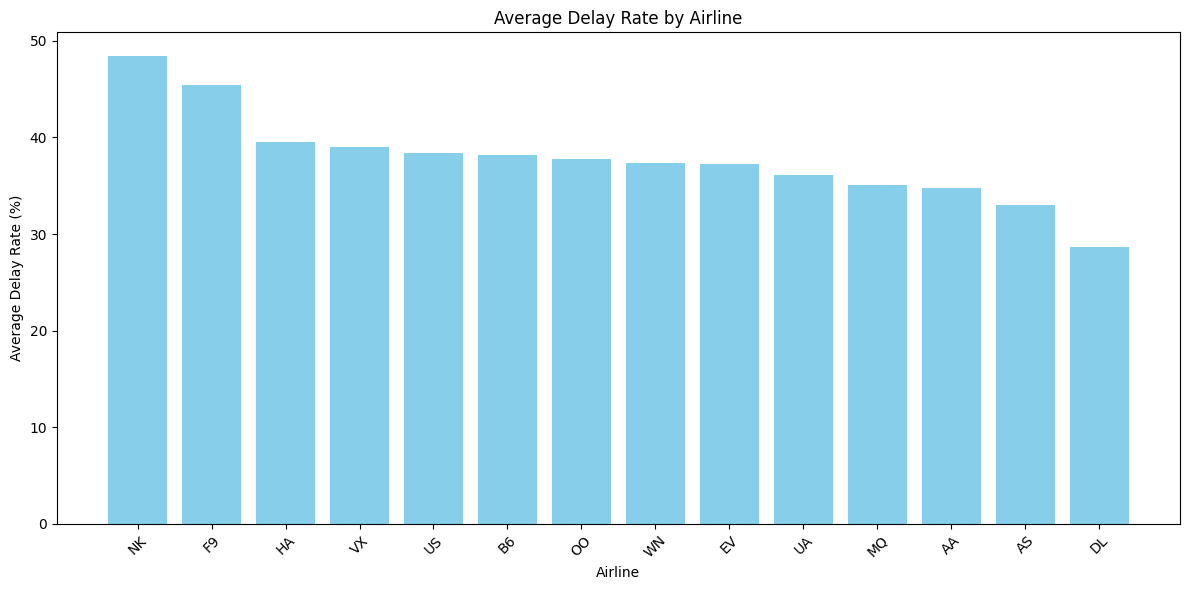

In [ ]:
import matplotlib.pyplot as plt

# Convert delay_rate to Pandas DataFrame for visualization
delay_rate_pd = delay_rate.toPandas()

# Plot the average delay rate by airline
plt.figure(figsize=(12, 6))
plt.bar(delay_rate_pd['AIRLINE'], delay_rate_pd['delay_rate'], color='skyblue')
plt.xlabel('Airline')
plt.ylabel('Average Delay Rate (%)')
plt.title('Average Delay Rate by Airline')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


3.2. Visualizing Delay Patterns Over Days of the Week

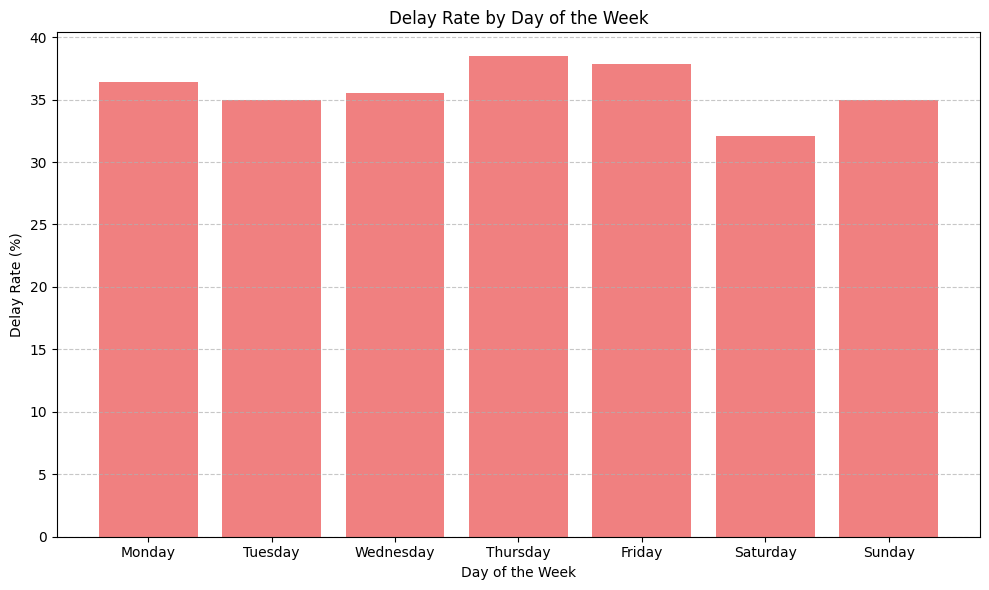

In [ ]:
import matplotlib.pyplot as plt

# Convert delay_by_day to Pandas DataFrame for visualization
delay_by_day_pd = delay_by_day.toPandas()

# Plot the delay rate by day of the week
plt.figure(figsize=(10, 6))
plt.bar(delay_by_day_pd['DAY_OF_WEEK'], delay_by_day_pd['delay_rate'], color='lightcoral')
plt.xlabel('Day of the Week')
plt.ylabel('Delay Rate (%)')
plt.title('Delay Rate by Day of the Week')
plt.xticks(delay_by_day_pd['DAY_OF_WEEK'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


3.3. Visualizing Delay Patterns Over Months

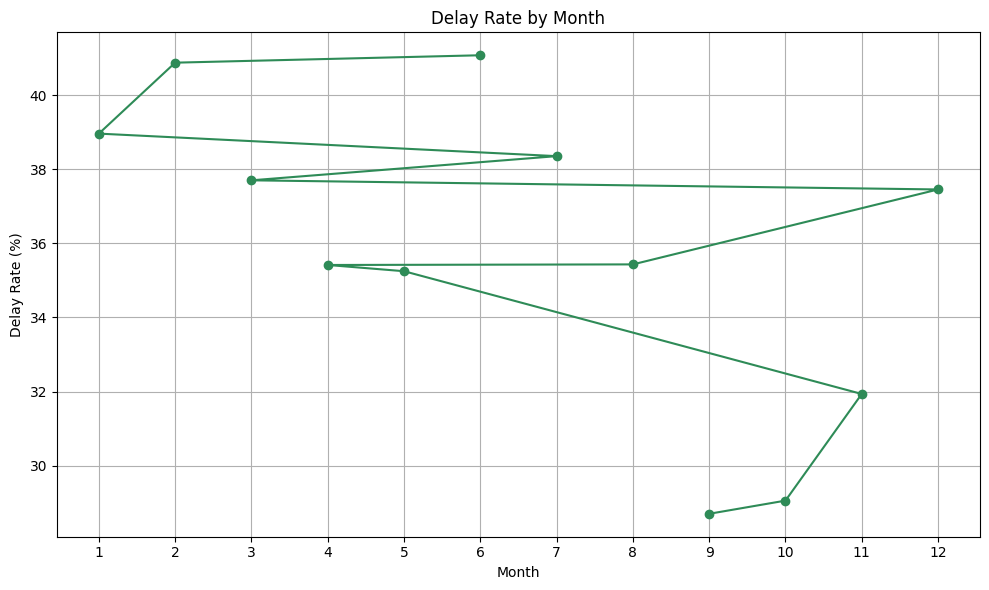

In [ ]:
# Convert delay_by_month to Pandas DataFrame for visualization
delay_by_month_pd = delay_by_month.toPandas()

# Plot delay rate by month
plt.figure(figsize=(10, 6))
plt.plot(delay_by_month_pd['MONTH'], delay_by_month_pd['delay_rate'], marker='o', color='seagreen')
plt.xlabel('Month')
plt.ylabel('Delay Rate (%)')
plt.title('Delay Rate by Month')
plt.xticks(delay_by_month_pd['MONTH'])
plt.grid(True)
plt.tight_layout()
plt.show()


Which airlines had the highest average delays?


NK (Spirit Airlines): With a delay rate of approximately 48.46%, this airline experiences the highest average delays compared to others.

What Patterns Did You Observe in Delays by Day of the Week?

Delays are highest on Mondays: Monday (Day 1) has the highest delay rate at 2.43%. This could be due to issues related to weekend scheduling, or the cumulative effect of weekend disruptions.

Mid-week delays are relatively lower: Days like Tuesday (Day 2) and Wednesday (Day 3) tend to have somewhat lower delays, with rates of 1.78% and 1.25%, respectively
.
Delays are lowest on Fridays: Friday (Day 5) has the lowest delay rate at 1.02%, which might indicate that the airlines are more prepared for the weekend travel rush, or that fewer operational issues occur at the end of the workwee
k.
Saturday and Sunday (Days 6 and 7) have mid-level delays but are lower than Mondays. This could be attributed to weekend travel surges, but not as significant as the start of the we

ek.
Summary of Delay Tre

nds:
Airlines with the highest delays: NK, F9
, HA.
Delays by day of the week: Mondays have the highest delays, with a general trend of decreasing delays as the week progresses, with Fridays being the least delaye
d day.
These patterns suggest that delays are more frequent early in the week, possibly due to scheduling issues, operational backlog, or weather conditions, and tend to reduce toward the w
eekend.

4. Summary of Findings

This exploratory data analysis (EDA) focused on flight data to understand delay and cancellation patterns across airlines, days of the week, months, and airports. Using SQL queries and visualizations, we identified several key trends and insights:

1. Airline Delay Rates:
Spirit Airlines (NK) and Frontier Airlines (F9) experienced the highest average delay rates, with delays reported on 48.46% and 45.39% of their flights, respectively.
Hawaiian Airlines (HA) also had significant delays, with a rate of approximately 39.57%.
Airlines like Delta (DL) and American Airlines (AA) had lower delay rates, with 28.64% and 34.73% of their flights delayed, respectively.
2. Delay Patterns by Day of the Week:
Mondays (Day 1) had the highest delay rate (2.43%), which could be due to scheduling issues or the backlog from weekend operations.
Mid-week days (Tuesday, Wednesday, and Thursday) exhibited lower delay rates, with Tuesday (Day 2) showing the second-lowest delays (1.78%) and Wednesday (Day 3) at 1.25%.
Fridays had the lowest delay rate (1.02%), suggesting better operational efficiency or fewer disruptions at the end of the workweek.
Saturday and Sunday (Days 6 and 7) displayed moderate delay rates but were still less than Mondays.
3. Cancellations:
Cancellations were most frequent in February, with a cancellation rate of approximately 4.78%. This could be linked to seasonal weather conditions or operational challenges.
January and March had lower cancellation rates, at 2.55% and 2.18%, respectively.
June and December saw higher cancellation rates (1.81% and 1.68%), possibly due to seasonal factors like holidays or weather-related disruptions.
4. Airports and Flight Cancellations:
Smaller airports like ITH (Ithaca Tompkins Regional Airport) had the highest cancellation rate (11.76%), while larger hubs like JFK showed relatively lower rates of cancellations.
Other airports with high cancellation rates included MMH (Mammoth Yosemite Airport) and SUN (Sun Valley Airport), likely due to limited infrastructure or weather-related challenges.
5. Delays and Cancellations by Month:
February had the highest cancellation rate, while June showed the highest delay rates, likely due to the increase in summer travel and weather disruptions.
Conclusion:
This analysis provides valuable insights into flight operations. Airlines such as NK and F9 have significant room for improvement in terms of reducing delays. Additionally, delays tend to be more frequent at the beginning of the week, while cancellations are more prevalent during winter months, possibly due to seasonal challenges. Airports with limited infrastructure and smaller regional hubs tend to have higher cancellation rates, suggesting a need for better operational planning during peak travel times.